In [1]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from io import BytesIO
np.random.seed(0) # reproducibility
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from scipy.fft import fft
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import Holt

def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Values", ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

def fft_analysis(signal):
    
    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept 
    detrended = signal - trend 
    
    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")
    
    return dominant_period, positive_frequencies, magnitudes

def mse(observations, estimates):
    """
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    """
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = np.mean(sq_diff)
    
    return mse

def weighted_moving_average(observations, weights, forecast=False):
    
    if len(weights) != len(observations[0:len(weights)]):
        raise ValueError("Length of weights must match the window size")
    
    # Normalize weights
    weights = np.array(weights) / np.sum(weights)
    
    # Initialize the result array
    result = np.empty(len(observations)-len(weights)//2)
    result[:] = np.nan
    
    # Calculate weighted moving average
    for i in range(len(weights)//2, len(result)):
        window = observations[i-(len(weights)//2):i+len(weights)//2+1]
        result[i] = np.dot(window, weights)
    
    # Handle forecast option
    if forecast:
        result = np.insert(result, 0, np.nan*np.ones(len(weights)//2+1))
        observations = np.append(observations, np.nan*np.ones(len(weights)//2))
        return observations, result
    else:
        return result

In [2]:
# Load the first time series
response = requests.get("https://zenodo.org/records/10897398/files/smoothing_ts1.npy?download=1")
response.raise_for_status()
smoothing_ts1 = np.load(BytesIO(response.content))
print(len(smoothing_ts1))

# Load the second time series
response = requests.get("https://zenodo.org/records/10897398/files/smoothing_ts4_4.npy?download=1")
response.raise_for_status()
smoothing_ts2 = np.load(BytesIO(response.content))
print(len(smoothing_ts2))

144
1000


## EXERCISES
Using on what you learned in this and in the previous lectures, do the following.

1. Create two time variables called `mytime1` and `mytime2` that starts at 0 and are as long as each dataset.
2. Split each dataset into train and test sets (as the test, use the last 5 observations).
3. Identify trend and seasonality, if present.
4. Identify if trend and/or seasonality are additive or multiplicative, if present.
5. Create smoothed model on the train set and use to forecast on the test set.
6. Calculate MSE on test data.
7. Plot training data, test data, and your model's forecast for each dataset.

### Points 1 + 2

In [3]:
# ------------ POINT 1 ------------ 
mytime1 = np.arange(0, len(smoothing_ts1), 1)
mytime2 = np.arange(0, len(smoothing_ts2), 1)
# ------------ POINT 2 2 ------------ 
train_1 = smoothing_ts1[:-5]
test_1 = smoothing_ts1[-5:]
train_2 = smoothing_ts2[:-5]
test_2 = smoothing_ts2[-5:]



### POINT 3 + 4

First lets look at the TS using the sequence plot

<Axes: title={'center': 'Time series 2'}, xlabel='Time', ylabel='Values'>

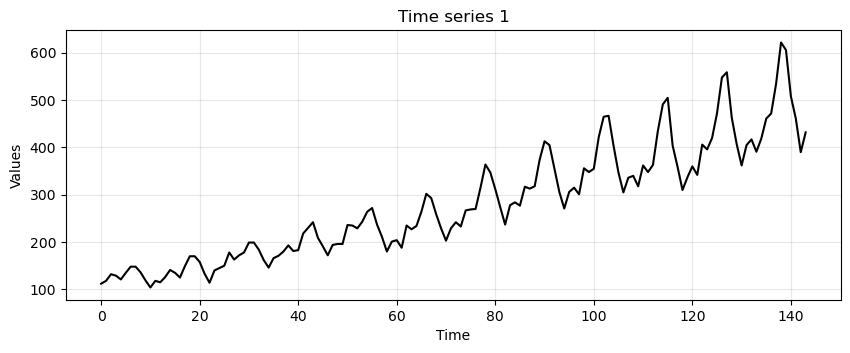

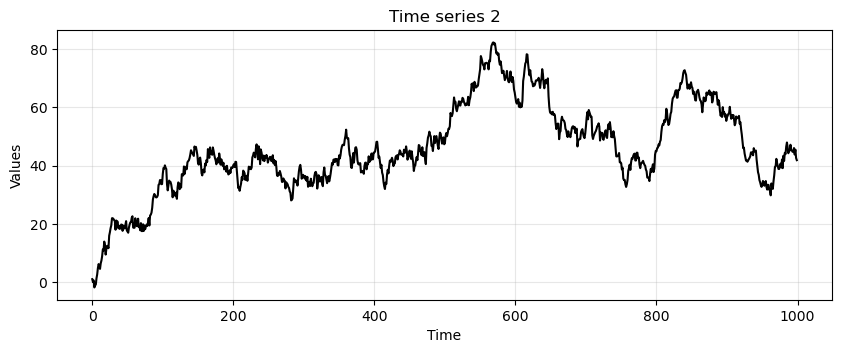

In [4]:
run_sequence_plot(mytime1, smoothing_ts1, "Time series 1")
run_sequence_plot(mytime2, smoothing_ts2, "Time series 2")

- The first time series is muliplicative (same as notebook 1, with multiplicative seasonal component), we can identify trend and seasonality using seasonal_decompose.
- The second one does not have a clear trend. It might have some small periodic fluctiation, but they can be also noise.
- Lets try to use FFT to inspect this further.

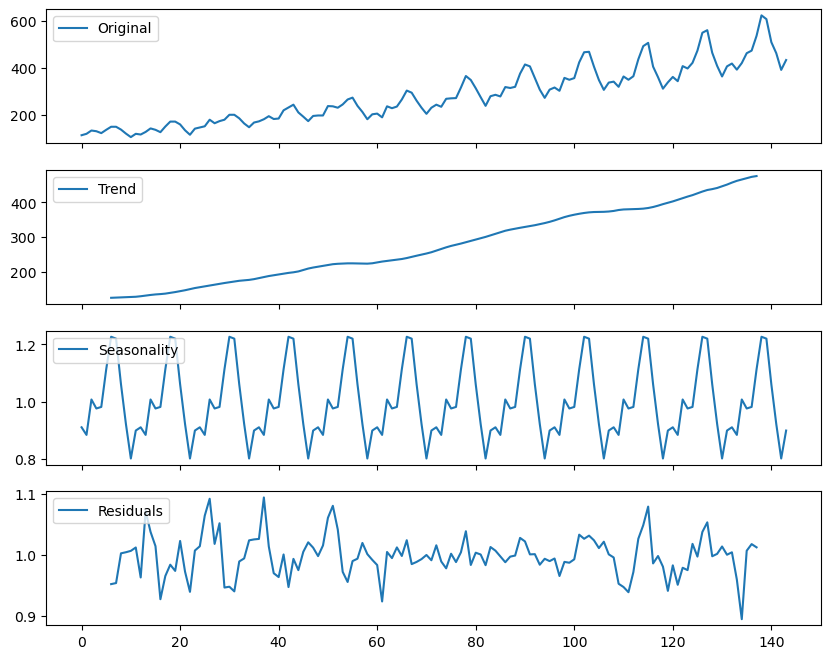

In [5]:
ts1_decomposition = seasonal_decompose(x=smoothing_ts1, model='multiplicative', period=12)

def seas_decomp_plots(original, decomposition):
    _, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(10, 8))
    axes[0].plot(original, label='Original')
    axes[0].legend(loc='upper left')
    axes[1].plot(decomposition.trend, label='Trend')
    axes[1].legend(loc='upper left')
    axes[2].plot(decomposition.seasonal, label='Seasonality')
    axes[2].legend(loc='upper left')
    axes[3].plot(decomposition.resid, label='Residuals')
    axes[3].legend(loc='upper left')
    plt.show()

seas_decomp_plots(smoothing_ts1, ts1_decomposition)


Dominant Frequency: 0.001
Dominant Period: 1000.00 time units


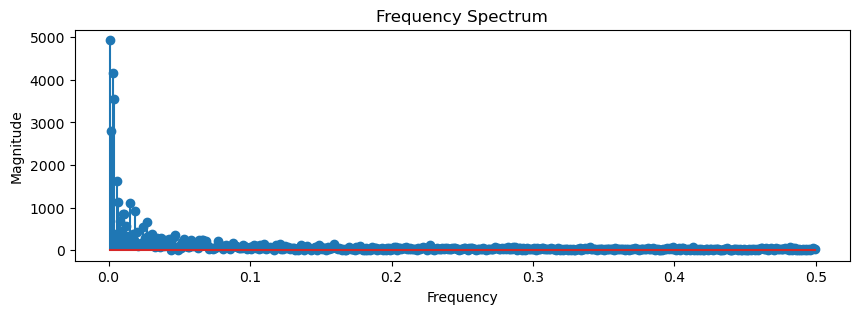

In [6]:
period, freqs, magnitudes = fft_analysis(smoothing_ts2)
# Plotting the spectrum
plt.figure(figsize=(10, 3))
plt.stem(freqs, magnitudes)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

The TS2 have no significant seasonal components.

### POINT 5 + 6 + 7

- The first time series has a strong seasonal component. We can use a triple exponential smoothing to capture its seasonality.

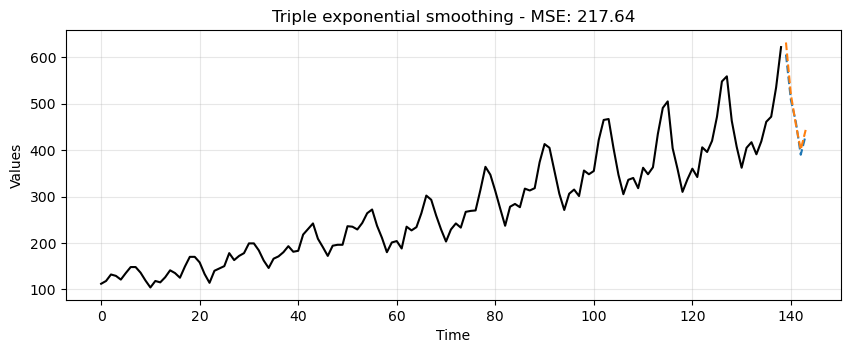

In [7]:
triple = ExponentialSmoothing(train_1,
                              trend="multiplicative",
                              seasonal="multiplicative",
                              seasonal_periods=12).fit(optimized=True)
triple_preds = triple.forecast(len(test_1))
triple_mse = mse(test_1, triple_preds)

ax = run_sequence_plot(mytime1[:-5], train_1, title=f"Triple exponential smoothing - MSE: {triple_mse:.2f}")
ax.plot(mytime1[-5:], test_1, color='tab:blue', linestyle="--", label="test")
ax.plot(mytime1[-5:], triple_preds, color='tab:orange', linestyle="--", label="preds");

The second time series has no seasonality, but has a strong noise component. The trend is not costant but still locally present.
- We can use double exponential smoothing to capture the trend and perform the prediction.
- Problem: The trend of the series is not costant, the total trend is = 0
- Solution: train the double exp. smoothing only on the last 30 samples of the train set, to capture only the local trend, which is not constant.

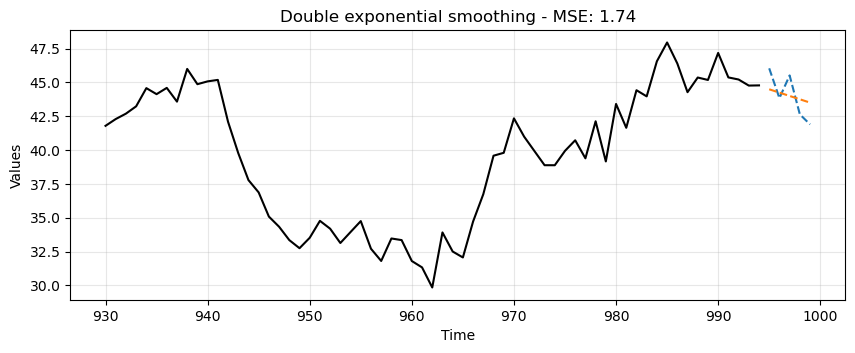

In [8]:
double = Holt(train_2[-30:]).fit(optimized=True)
double_preds = double.forecast(len(test_2))
double_mse = mse(test_2, double_preds)
ax = run_sequence_plot(mytime2[-70:-5], train_2[-65:], title=f"Double exponential smoothing - MSE: {double_mse:.2f}")
ax.plot(mytime2[-5:], test_2, color='tab:blue', linestyle="--", label="test")
ax.plot(mytime2[-5:], double_preds, color='tab:orange', linestyle="--", label="preds");